# Practical: Automated Feedback from Physiological Data for Time Perception
Welcome to the practical on automated feedback from physiological data for time perception.
In this practical you will learn about the following 4 topics:
1. Data cleaning: Removing noise and artifacts from the raw data.
2. Feature extraction: Identifying relevant features from the cleaned data that are indicative of time perception.
3. Classification: Using machine learning algorithms to classify data based on extracted features.
4. Additional steps: Exploring advanced techniques such as feature selection methods, feature importance measurements, and automated machine learning (AutoML).

We will use the same data as Aust et al. 2024 (https://arxiv.org/abs/2404.15213). For simplicity, we will only use electrodermal activity (EDA) data.
So without further ado, let's get started!
First you will import required libraries.

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install neurokit2
import neurokit2 as nk

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

!pip install shap
import shap
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

!pip install naiveautoml
import naiveautoml
import logging

# connect your drive
from google.colab import drive
drive.mount('/content/drive')

# 1. Data Cleaning
Great! Now we have all required libraries imported. Next, we will load the data.

In [76]:
# load the raw EDA data
raw_eda = pd.read_csv('/content/drive/MyDrive/chios_summer_school-main/data/physiological/EDA/subject1-1_EDA.csv')

# display the overall shape and the column names of the data
print(f"shape of the data: {raw_eda.shape}, columns: {raw_eda.columns}")

# display the first few rows of the data
raw_eda.head()

shape of the data: (2666, 2), columns: Index(['LocalTimestamp', 'EA'], dtype='object')


,LocalTimestamp,EA
0,1.659430e+09,0.303275
1,1.659430e+09,0.304391
2,1.659430e+09,0.304428
3,1.659430e+09,0.303463
4,1.659430e+09,0.303239


Okay, the data consists of a `LocalTimestamp` and `EA` that is the raw EDA data. Next, we will plot the raw EDA data.

Text(0.5, 1.0, 'Raw EDA data')

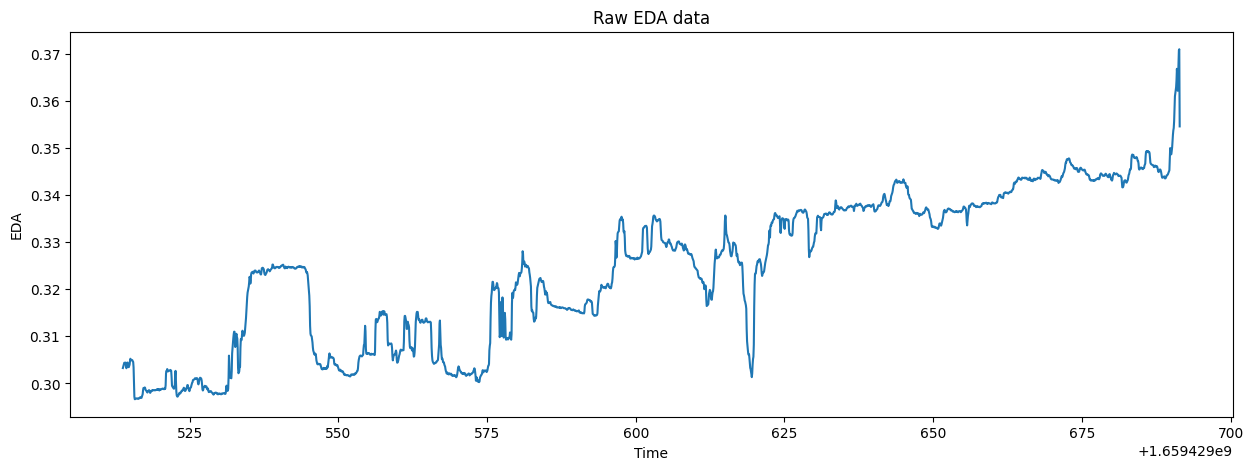

In [77]:
# plot the raw EDA data
plt.figure(figsize=(15, 5))
plt.plot(raw_eda['LocalTimestamp'], raw_eda['EA'])
plt.xlabel('Time')
plt.ylabel('EDA')
plt.title('Raw EDA data')

You may have noticed that the time axis does not tell you anything. To make it more informative, we will convert the `LocalTimestamp` to a more readable format. We can do this by subtracting the first timestamp from all timestamps such that each experiment starts at 0.

Text(0.5, 1.0, 'Raw EDA data')

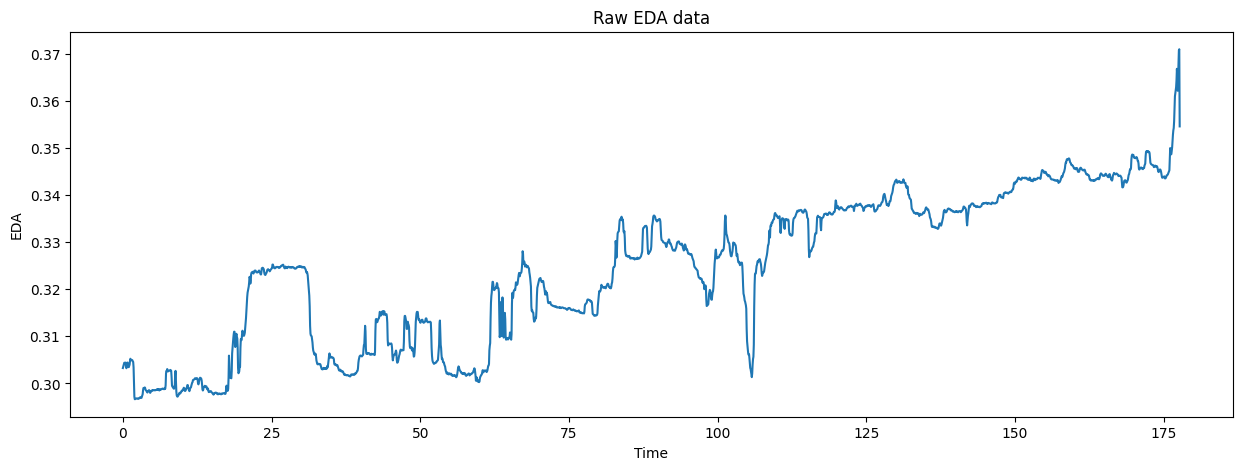

In [78]:
# subtract the first time stamp from all other time stamps an plot the data again
raw_eda['LocalTimestamp'] = raw_eda['LocalTimestamp'] - raw_eda['LocalTimestamp'].iloc[0]

# plot the raw EDA data
plt.figure(figsize=(15, 5))
plt.plot(raw_eda['LocalTimestamp'], raw_eda['EA'])
plt.xlabel('Time')
plt.ylabel('EDA')
plt.title('Raw EDA data')

Now the time make sense, it seems that the experiment lasted for about 180 seconds or 3 minutes. Next, we will clean the data to remove noise and artifacts. Therefore, we use the NeuroKit library we imported earlier. Before we can clean the data we need to know the sampling rate of our data because this information is a parameter we need to hand over to the cleaning method.

In [79]:
# calculate the sampling rate of the eda data in Hz
sampling_rate = 1 / np.mean(np.diff(raw_eda['LocalTimestamp']))
sampling_rate_int = int(np.round(sampling_rate, 0))

print(f"Sampling rate: {sampling_rate} Hz")
print(f"Rounded sampling rate: {sampling_rate_int} Hz")

# clean the data using the NeuroKit library
#  You can check out the documentation here: https://neuropsychology.github.io/NeuroKit/functions/eda.html
#  You can use report="subject_1_report.html" to print a visual overview of the cleaning process
cleaned_eda_signals, info = nk.eda_process(raw_eda['EA'], sampling_rate=sampling_rate_int)

Sampling rate: 14.999506503197164 Hz
Rounded sampling rate: 15 Hz


The `cleaned_eda_signals` contain the cleaned EDA data. `info` contains information of each SCR peak and sampling frequency.
Now, we can plot the individual EDA components, needed for calculating the features.

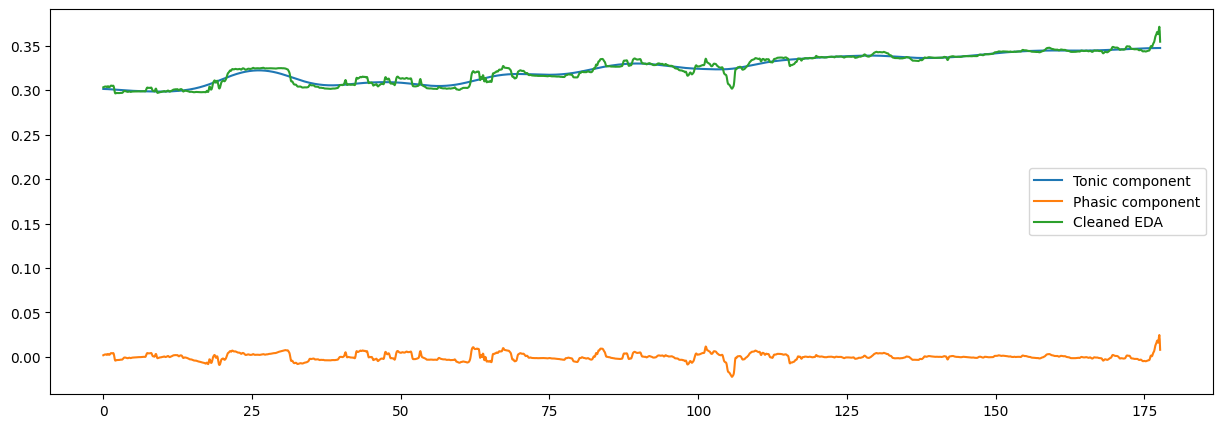

In [80]:
# plot the individual EDA components
plt.figure(figsize=(15, 5))
plt.plot(raw_eda['LocalTimestamp'], cleaned_eda_signals['EDA_Tonic'], label="Tonic component")
plt.plot(raw_eda['LocalTimestamp'], cleaned_eda_signals['EDA_Phasic'], label="Phasic component")
plt.plot(raw_eda['LocalTimestamp'], cleaned_eda_signals['EDA_Clean'], label="Cleaned EDA")
plt.legend()

## 2. Feature Extraction
Next, we can use the cleaned EDA data to extract features. We will use the following features: SCR peaks, SCR peak amplitude mean, EDA tonic standard deviation, EDA sympathetic, EDA sympathetic N, EDA autocorrelation. The NeuroKit library provides a function to extract these features.

In [81]:
# extract features from the cleaned EDA data
#  method can be "interval-related" or "event-related" (event-related is for sequences under 10 seconds) and we are using an interval and not events
eda_features = nk.eda_analyze(cleaned_eda_signals, sampling_rate=sampling_rate_int, method="interval-related")

Great, now we have extracted the EDA features. Now we need to get the subjective time perception of the participants.
We start by loading the questionnaire answers of all participants.

In [82]:
# load the questionnaire answers
questionnaire = pd.read_csv('/content/drive/MyDrive/chios_summer_school-main/data/timings.csv')

# display the first few rows of the data
print(questionnaire.head())

   ParticipantID  Session  p1Asked  p1Produced  p2Asked  p2Produced  \
0              1        1       25          26       32          40   
1              1        2       35          37       32          30   
2              1        3       34          30       35          39   
3              1        4       33          35       34          42   
4              2        1       32          30       32          25   

   SessionTimeActual  SessionTimeEstimated  PassageOfTimeSlowFast  MentalTLX  \
0                114                   120                      2         35   
1                110                    60                      2         35   
2                129                   180                      5         60   
3                131                   240                      5         65   
4                115                   120                      3         50   

   PhysicalTLX  TemporalTLX  PerformanceTLX  EffortTLX  FrustrationTLX  
0           10     

The important columns are `ParticipantID` and `Session` to assign the corresponding answer to the setting and participant. Further, the column `PassageOfTimeSlowFast` provides us with the answer of slow or fast subjective time perception.
So now we can extract the answer for the first participant and first session.
(The mapping is 1: very slow, 2: slow, 3: normal, 4: fast, 5: very fast)

In [83]:
# select the subjective time perception of participant 1 in session 1
subjective_time_perception_label = questionnaire[(questionnaire['ParticipantID'] == 1) & (questionnaire['Session'] == 1)]['PassageOfTimeSlowFast'].values[0]

# print the subjective time perception
print(f"Subjective time perception of participant 1 in session 1: {subjective_time_perception_label}")

Subjective time perception of participant 1 in session 1: 2


Now you learned how you can get the features and the appropriate labels. In the next step you will automate the process for all participants and sessions.

In [84]:
# define the participants
participants = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# define the sessions
sessions = [1, 2, 3, 4]

# final Pandas dataframe that holds all data
all_data = pd.DataFrame(columns=["participant", "session", "SCR_Peaks_N",
                    "SCR_Peaks_Amplitude_Mean",
                    "EDA_Tonic_SD",
                    "EDA_Sympathetic",
                    "EDA_SympatheticN",
                    "EDA_Autocorrelation", "subjective_time_perception"])
counter = 0

# iterate over all participants
for p in participants:
    # iterate over all sessions
    for s in sessions:
        # load the raw EDA data
        eda_raw = pd.read_csv(f'data/physiological/EDA/subject{p}-{s}_EDA.csv')
        # subtract the first time stamp from all other time stamps
        eda_raw['LocalTimestamp'] = eda_raw['LocalTimestamp'] - eda_raw['LocalTimestamp'].iloc[0]
        # calculate the sampling rate of the eda data in Hz
        sampling_rate = int(np.round(1 / np.mean(np.diff(eda_raw['LocalTimestamp'])), 0))

        # clean the data using the NeuroKit library
        cleaned_eda_signals, info = nk.eda_process(eda_raw['EA'], sampling_rate=sampling_rate)

        # extract features from the cleaned EDA data
        eda_features = nk.eda_analyze(cleaned_eda_signals, sampling_rate=sampling_rate, method="interval-related")

        # select the subjective time perception of the participant in the session
        subjective_time_perception_label = questionnaire[(questionnaire['ParticipantID'] == p) & (questionnaire['Session'] == s)]['PassageOfTimeSlowFast'].values[0]

        # append the data to the final dataframe
        all_data.loc[counter] = [p, s, float(eda_features["SCR_Peaks_N"].iloc[0]), float(eda_features["SCR_Peaks_Amplitude_Mean"].iloc[0]), float(eda_features["EDA_Tonic_SD"].iloc[0]), float(eda_features["EDA_Sympathetic"].iloc[0]), float(eda_features["EDA_SympatheticN"].iloc[0]), float(eda_features["EDA_Autocorrelation"].iloc[0]), subjective_time_perception_label]
        counter += 1

Great! Now you have all the data in one place. Next, we will use machine learning to classify the data based on the extracted features.
Therefore, we first split the data into training and test data. We will use 80% of the data for training and 20% for testing.

In [85]:
# split the data into training and testing data (80% training, 20% testing)
#  random_state is set to 42 to ensure reproducibility
x_train, x_test, y_train, y_test = train_test_split(all_data[["SCR_Peaks_N", "SCR_Peaks_Amplitude_Mean", "EDA_Tonic_SD", "EDA_Sympathetic", "EDA_SympatheticN", "EDA_Autocorrelation"]], all_data["subjective_time_perception"], test_size=0.2, random_state=42)

print(f"X train shape: {x_train.shape}, X test shape: {x_test.shape}, y train shape: {y_train.shape}, y test shape: {y_test.shape}")

X train shape: (38, 6), X test shape: (10, 6), y train shape: (38,), y test shape: (10,)


## 3. Classification
Now we can use the training data to train our classifier and evaluate it on the test data.

In [86]:
# create classifier
#  see: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html for more information and hyperparameter selection
dtc = DecisionTreeClassifier(random_state=42)

# train the classifier
dtc.fit(x_train, y_train)

# evaluate the classifier
#  predict the labels of the test data
y_pred = dtc.predict(x_test)
#  predict the probabilities of the test data
y_pred_proba = dtc.predict_proba(x_test)

# calculate the accuracy of the classifier
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# calculate the F1 score of the classifier
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")
# calculate the ROC AUC score of the classifier
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred_proba, average='micro', multi_class='ovr')}")


Accuracy: 0.1
F1 score: 0.12000000000000002
ROC AUC score: 0.43750000000000006


## 4. Additional steps
Great! You have successfully trained and evaluated a classifier to predict subjective time perception based on EDA features.
However, the results are not so satisfying yet. Therefore, we will explore additional steps to improve the classification performance.
Let's start with simplifying the problem by reducing the number of classes.

Text(0, 0.5, 'Frequency')

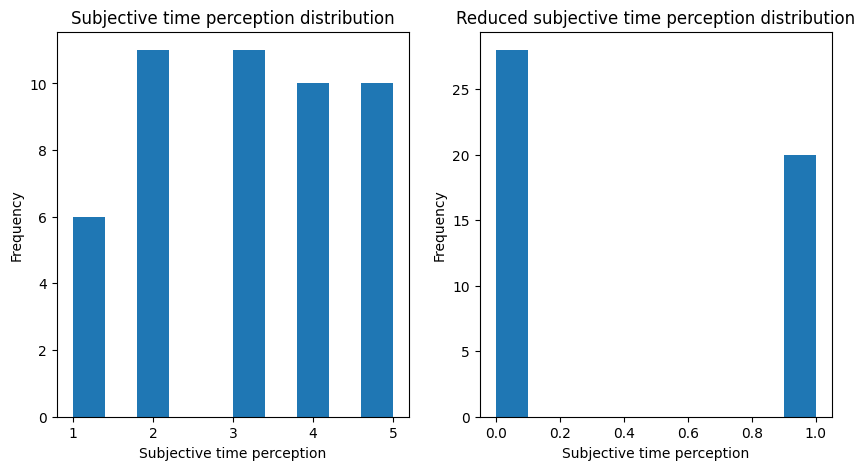

In [87]:
# reduce the number of classes to slow and fast
all_data['subjective_time_perception_reduced'] = all_data['subjective_time_perception'].apply(lambda x: 0 if x <= 3 else 1)

# lets see the distribution of the classes before and after
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(all_data['subjective_time_perception'])
plt.title('Subjective time perception distribution')
plt.xlabel('Subjective time perception')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(all_data['subjective_time_perception_reduced'])
plt.title('Reduced subjective time perception distribution')
plt.xlabel('Subjective time perception')
plt.ylabel('Frequency')

This simplified the problem. Let's train and evaluate the classifier again. We will try a different classifier this time: Random Forest (ensemble of decision trees).

In [88]:
# use the reduced label
x_train, x_test, y_train, y_test = train_test_split(all_data[["SCR_Peaks_N", "SCR_Peaks_Amplitude_Mean", "EDA_Tonic_SD", "EDA_Sympathetic", "EDA_SympatheticN", "EDA_Autocorrelation"]], all_data["subjective_time_perception_reduced"], test_size=0.2, random_state=42)

print(f"X train shape: {x_train.shape}, X test shape: {x_test.shape}, y train shape: {y_train.shape}, y test shape: {y_test.shape}")


rfc = RandomForestClassifier(n_estimators=1024, random_state=42)

# train the classifier
rfc.fit(x_train, y_train)

# evaluate the classifier
#  predict the labels of the test data
y_pred = rfc.predict(x_test)

# calculate the accuracy of the classifier
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# calculate the F1 score of the classifier
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")
# calculate the ROC AUC score of the classifier
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred)}")

X train shape: (38, 6), X test shape: (10, 6), y train shape: (38,), y test shape: (10,)
Accuracy: 0.7
F1 score: 0.72
ROC AUC score: 0.625


Great! The classification performance improved. Next, we will explore feature importance to identify the most relevant features.
Therefore, we will use shape-based feature importance.

  0%|          | 0/10 [00:00<?, ?it/s]

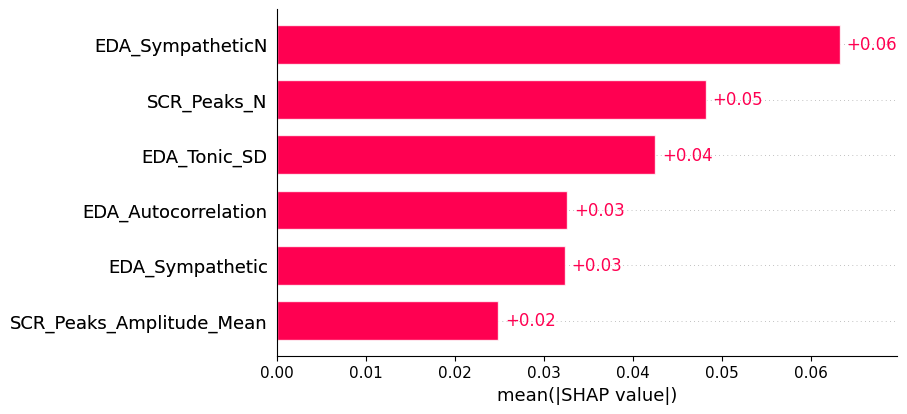

In [89]:
# create the explainer
explainer = shap.KernelExplainer(rfc.predict_proba, x_train)
# calculate the shap values based on the test data
shap_value = explainer(x_test)
# returns probability for class 0 and 1, but we only need one bc p = 1 - p
shap_value.values = shap_value.values[:, :, 1]
shap_value.base_values = shap_value.base_values[:, 1]

# plot the feature importance
plt.figure()
shap.plots.bar(shap_value, max_display=6, show=True)

Seeing that some features are more important than others, we can try to remove the less important features and retrain the classifier.

In [90]:
# create a sequential feature selector
selector = SequentialFeatureSelector(rfc, n_features_to_select=3, direction="forward", tol=0.001)
# fit the selector based on the training data
x_train = selector.fit_transform(x_train, y_train)
# transform the test data accordingly
x_test = selector.transform(x_test)

# store results
result_df = pd.DataFrame(zip(["SCR_Peaks_N", "SCR_Peaks_Amplitude_Mean", "EDA_Tonic_SD", "EDA_Sympathetic", "EDA_SympatheticN", "EDA_Autocorrelation"], selector.get_support()))
result_df.columns = ["features", "used"]

# print the results
print(result_df)

# train the classifier
rfc.fit(x_train, y_train)

# evaluate the classifier
#  predict the labels of the test data
y_pred = rfc.predict(x_test)

# calculate the accuracy of the classifier
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# calculate the F1 score of the classifier
print(f"F1 score: {f1_score(y_test, y_pred, average='weighted')}")
# calculate the ROC AUC score of the classifier
print(f"ROC AUC score: {roc_auc_score(y_test, y_pred)}")

                   features   used
0               SCR_Peaks_N   True
1  SCR_Peaks_Amplitude_Mean  False
2              EDA_Tonic_SD   True
3           EDA_Sympathetic  False
4          EDA_SympatheticN   True
5       EDA_Autocorrelation  False
Accuracy: 0.6
F1 score: 0.6
ROC AUC score: 0.375


Finally, we can have a look at automated model selection, which can be helpful to find the correct hyperparameters for the classifier.

In [91]:
# do logging
logger = logging.getLogger('naiveautoml')
logger.setLevel(logging.INFO)
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)

# create the NaiveAutoML object
naml = naiveautoml.NaiveAutoML(max_hpo_iterations=20, show_progress=True, scoring="accuracy")

# fit the NaiveAutoML object
naml.fit(x_train, y_train)

# print the best model
print("---------------------------------")
print(naml.chosen_model)
print("---------------------------------")

2024-07-18 11:50:53,235 - naiveautoml.evalpool - INFO - This is a small dataset, choosing mccv-5 for evaluation
2024-07-18 11:50:53,235 - naiveautoml.evalpool - INFO - This is a small dataset, choosing mccv-5 for evaluation
2024-07-18 11:50:53,236 - naiveautoml - INFO - Automatically inferred task type: classification
2024-07-18 11:50:53,236 - naiveautoml - INFO - Automatically inferred task type: classification
2024-07-18 11:50:53,248 - naiveautoml - INFO - There are 0 categorical features, which will be binarized.
2024-07-18 11:50:53,248 - naiveautoml - INFO - There are 0 categorical features, which will be binarized.
2024-07-18 11:50:53,249 - naiveautoml - INFO - Missing values for the different attributes are [0 0 0].
2024-07-18 11:50:53,249 - naiveautoml - INFO - Missing values for the different attributes are [0 0 0].
2024-07-18 11:50:53,249 - naiveautoml - INFO - Optimizing pipeline under the following conditions.
                
        Input type: <class 'numpy.ndarray'> (spa

Progress for algorithm selection:


  0%|          | 0/31 [00:00<?, ?it/s]2024-07-18 11:50:53,252 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:50:53,252 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:50:53,252 - naiveautoml - INFO - Selecting component for step with name: learner
2024-07-18 11:50:53,252 - naiveautoml - INFO - Selecting component for step with name: learner
2024-07-18 11:50:53,252 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:50:53,252 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:50:53,254 - naiveautoml.evalpool - INFO - Initializing evaluation of Pipeline(steps=[('learner', ExtraTreesClassifier())]). Current memory consumption 559MB. Now awaiting results.
2024-07-18 11:50:53,254 - naiveautoml.evalpool - INFO - Initializing evaluation of Pipeline(steps=[('learner', ExtraTreesClassifier())]). Current memory consumption 559MB. Now awaiting r

Progress for hyperparameter optimization:


  0%|          | 0/20 [00:00<?, ?it/s]2024-07-18 11:51:12,261 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:51:12,261 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:51:12,261 - naiveautoml - INFO - Entering HPO phase.
2024-07-18 11:51:12,261 - naiveautoml - INFO - Entering HPO phase.
2024-07-18 11:51:12,262 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:51:12,262 - naiveautoml - INFO - --------------------------------------------------
2024-07-18 11:51:12,262 - naiveautoml - INFO - Starting 1-th HPO step. Currently best known score is -inf
2024-07-18 11:51:12,262 - naiveautoml - INFO - Starting 1-th HPO step. Currently best known score is -inf
2024-07-18 11:51:12,264 - naiveautoml.evalpool - INFO - Initializing evaluation of Pipeline(steps=[('data-pre-processor', MinMaxScaler()),
                ('learner',
                 SVC(C=10.17432355288452, coef0=0.8954377

---------------------------------
Pipeline(steps=[('data-pre-processor', MinMaxScaler()),
                ('learner', SVC(kernel='sigmoid'))])
---------------------------------


In [92]:
# Testing the findings from the AutoML
svc = SVC(kernel="sigmoid", probability=True)

svc.fit(x_train, y_train)

y_pred = svc.predict(x_test)

# calculate the accuracy of the classifier
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.7


### Conclusion
Now you have learned the basics of processing and classifying physiological data for time perception. You have learned how to clean the data, extract features, classify the data, and explore additional steps to improve the classification performance.

It is time to explore the data on your own. You can try different classifiers, feature selection methods, and hyperparameter optimization techniques to improve the classification performance further. You can also try different features or even combine features from different physiological data sources to improve the classification performance.

In [93]:
# TODO play around!